Load in the Julia Machine learning packages, plotting package, and file loader, as well as custom utility functions

In [1]:
using Flux,Statistics,Plots,MLDataUtils,DelimitedFiles,StatsPlots
using Flux.Data: DataLoader
include("utilityfunc.jl")

evalmpe (generic function with 1 method)

Set bounds and scaler on baseline full integration model

In [2]:
#set lower and upper bounds on Lpt,Kt and Rs (Lpt is first element and Kt is second element and Rs is third element)
lb=Float32[5e-7,5e-7,5]
ub=Float32[5e-6,5e-6,30]

iscalerb(x)=(x-lb)./(ub-lb) #Define Min-Max Noramization function
inv_iscalerb(x)=x.*(ub.-lb).+lb

function iscalerbatchb(x)
    nfeat,sl = size(x)
    out=Array{Float32,2}(undef,nfeat,sl)
    for i=1:sl
        out[:,i]=iscalerb(x[:,i])
    end
    return out
end

function inv_iscalerbatchb(x)
    nfeat,sl = size(x)
    out=Array{Float32,2}(undef,nfeat,sl)
    for i=1:sl
        out[:,i]=inv_iscalerb(x[:,i])
    end
    return out
end

inv_iscalerbatchb (generic function with 1 method)

Set bounds and scaler on Dynamic models

In [3]:
conc_ub=Float32(.6)

i_lb=Float32[5e-7,7e-7,5.0,0.0,0.0]
i_ub=Float32[3.5e-6,4e-6,30,(300/3600),conc_ub]
iscaler(x)=(x-i_lb)./(i_ub-i_lb)
inv_iscaler(x)=x.*(i_ub.-i_lb).+i_lb
oscaler(x)= x ./ conc_ub
inv_oscaler(x)=x.*conc_ub

inv_oscaler (generic function with 1 method)

Load in the latest machine learning models

In [4]:
using BSON: @load
@load "m_baseline.bson" m_baseline
@load "m_MLP_f.bson" m_MLP
@load "m_RNN_f.bson" m_RNN
@load "m_LSTM_f.bson" m_LSTM

Set up models without scalers

In [5]:
NN_b(x)=inv_oscaler(m_baseline(iscalerb(x)))
NN_m(x)=inv_oscaler(m_MLP(iscaler(x)))
NN_r(x)=inv_oscaler(m_RNN(iscaler(x)))
NN_l(x)=inv_oscaler(m_LSTM(iscaler(x)))

NN_l (generic function with 1 method)

Read in just the test data and define characteristics

In [6]:
testdat=readdlm("TestData.csv",',',Float32);

In [7]:
ntestbatch=1000;
ntestsamp=ntestbatch*20;
nfeat=5; #5 features
ntarg=1; #1 target values
sl=20; #sequence length of 20

In [8]:
x_test = testdat[1:5,:];
y_test=testdat[6,:];

Set up baseline data

In [9]:
S=Array{Float32,2}(undef,3,ntestbatch)
Xn=inv_iscalerbatch(x_test)
for i=1:ntestbatch
    S[:,i]=Xn[1:3,20*i]
end
XS=iscalerbatchb(S);
YS=reshape(y_test,(20,ntestbatch));
YS_sc=inv_oscaler(YS);

Load in the points of interest that correspond to different cancer treatments from prior optimization study

In [10]:
data_oi=readdlm("data_oi.csv",',',Float32)
s_oi = data_oi[1:3,:];
y_oi=data_oi[4:end,:];
t=(300/3600)*(1/20)*[t for t=1:20];

Evaluate the MSE, the RMSE, and the MPE on the test set for the full integration MLP model

In [11]:
@show cust_mse(XS,YS,m_baseline);
@show RMSE(XS,YS,m_baseline);
@show mean_error_func(XS,YS,m_baseline);

cust_mse(XS, YS, m_baseline) = 2.6885914f-6
RMSE(XS, YS, m_baseline) = 0.0016396925f0
mean_error_func(XS, YS, m_baseline) = 0.7113812f0


Evaluate the MSE, the RMSE, and the MPE on the test set and the MPE on just biological parameters for the dynamic MLP models

In [12]:
@show cust_mse(x_test,y_test,m_MLP);
@show mean_error_func(x_test,y_test,m_MLP);
@show RMSE(x_test,y_test,m_MLP);
@show evalmpe(S,YS,m_MLP);

cust_mse(x_test, y_test, m_MLP) = 5.316399f-7
mean_error_func(x_test, y_test, m_MLP) = 0.551797f0
RMSE(x_test, y_test, m_MLP) = 0.0007291364f0
evalmpe(S, YS, m_MLP) = 39.406616f0


Evaluate the MSE, the RMSE, and the MPE on the test set and the MPE on just biological parameters for the dynamic RNN models

In [13]:
@show cust_mse(x_test,y_test,m_RNN);
@show mean_error_func(x_test,y_test,m_RNN);
@show RMSE(x_test,y_test,m_RNN);
Flux.reset!(m_RNN);
@show evalmpe(S,YS,m_RNN);

cust_mse(x_test, y_test, m_RNN) = 1.4627354f-6
mean_error_func(x_test, y_test, m_RNN) = 1.6145294f0
RMSE(x_test, y_test, m_RNN) = 0.001209436f0
evalmpe(S, YS, m_RNN) = 33.268154f0


Evaluate the MSE, the RMSE, and the MPE on the test set and the MPE on just biological parameters for the dynamic LSTM models

In [14]:
@show cust_mse(x_test,y_test,m_LSTM);
@show mean_error_func(x_test,y_test,m_LSTM);
@show RMSE(x_test,y_test,m_LSTM);
Flux.reset!(m_LSTM);
@show evalmpe(S,YS,m_LSTM);

cust_mse(x_test, y_test, m_LSTM) = 4.1018444f-7
mean_error_func(x_test, y_test, m_LSTM) = 0.8519007f0
RMSE(x_test, y_test, m_LSTM) = 0.00064045645f0
evalmpe(S, YS, m_LSTM) = 38.787144f0


Read in epoch vs validation error from spreadsheet and plot it

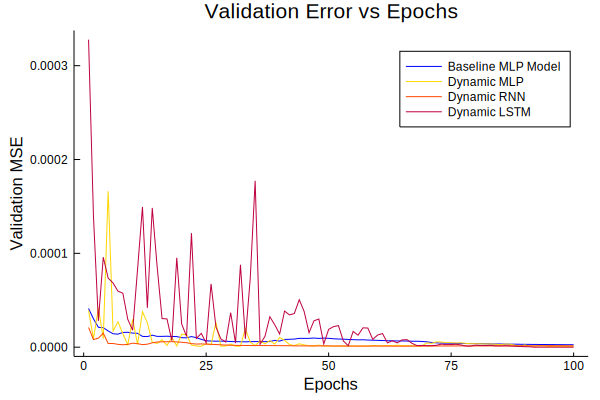

In [15]:
epochE=readdlm("EpochLog.csv",',',Float32);
plot(1:100,[epochE[:,1],epochE[:,2],epochE[:,3],epochE[:,4]],
title="Validation Error vs Epochs",
    ylabel="Validation MSE",
    xlabel="Epochs",
    label=["Baseline MLP Model" "Dynamic MLP" "Dynamic RNN" "Dynamic LSTM"],
    legend=:topright,
    grid=:off,
    #color_palette=[:blue,:gold,:darkorange,:red]
    color_palette=[:blue,:red,:darkorange,:gold]
)
#savefig("valepocherror.png")

Plot the accumulation profile of the mechanistic and all ML surrogate models at each of the samples of interest from past optimization study on the effect of different cancer treatments

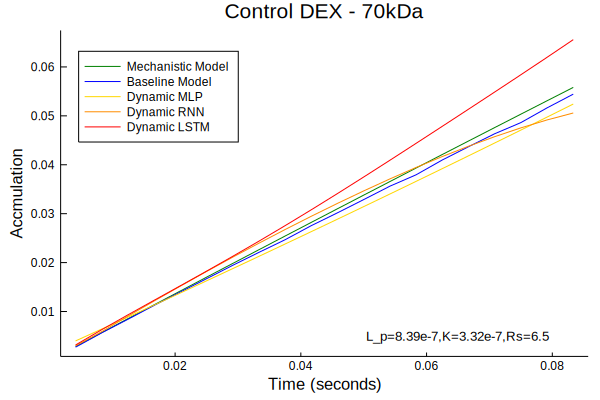

In [16]:
#Plot 1 - control DEX - 70kDa
Flux.reset!(m_LSTM)
Flux.reset!(m_RNN)
case=1
plot(t,
    [y_oi[:,case], NN_b(s_oi[:,case]),evalprofile(s_oi[:,case],m_MLP),evalprofile(s_oi[:,case],m_RNN),evalprofile(s_oi[:,case],m_LSTM)],
    title="Control DEX - 70kDa",
    ylabel="Accmulation",
    xlabel="Time (seconds)",
    label=["Mechanistic Model" "Baseline Model" "Dynamic MLP" "Dynamic RNN" "Dynamic LSTM"],
    legend=:topleft,
    grid=:off,
    #color_palette=[:green,:blue,:gold,:darkorange,:red]
    color_palette=[:green,:darkorange,:gold,:red,:blue]
)
annotate!(.065,0.005,("L_p=$(s_oi[1,case]),K=$(s_oi[2,case]),Rs=$(s_oi[3,case])",9))
#savefig("dexc_70.png")

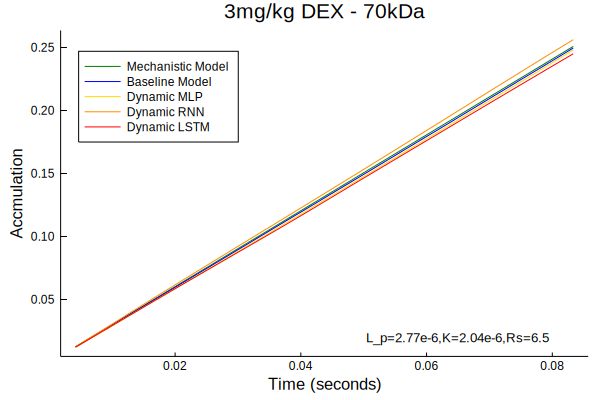

In [17]:
#Plot 2 - 3mg/kg DEX - 70kDa
Flux.reset!(m_LSTM)
Flux.reset!(m_RNN)
case=2
plot(t,
    [y_oi[:,case], NN_b(s_oi[:,case]),evalprofile(s_oi[:,case],m_MLP),evalprofile(s_oi[:,case],m_RNN),evalprofile(s_oi[:,case],m_LSTM)],
    title="3mg/kg DEX - 70kDa",
    ylabel="Accmulation",
    xlabel="Time (seconds)",
    label=["Mechanistic Model" "Baseline Model" "Dynamic MLP" "Dynamic RNN" "Dynamic LSTM"],
    legend=:topleft,
    grid=:off,
    #color_palette=[:green,:blue,:gold,:darkorange,:red]
    color_palette=[:green,:darkorange,:gold,:red,:blue]
)
annotate!(.065,0.02,("L_p=$(s_oi[1,case]),K=$(s_oi[2,case]),Rs=$(s_oi[3,case])",9))
#savefig("dex3_70.png")

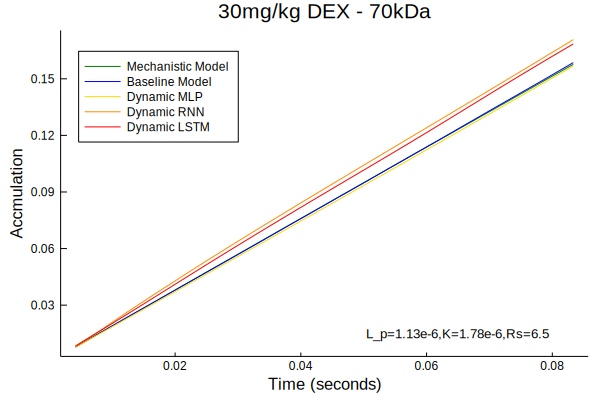

In [18]:
#Plot 3 - 30mg/kg DEX - 70kDa
Flux.reset!(m_LSTM)
Flux.reset!(m_RNN)
case=3
plot(t,
    [y_oi[:,case], NN_b(s_oi[:,case]),evalprofile(s_oi[:,case],m_MLP),evalprofile(s_oi[:,case],m_RNN),evalprofile(s_oi[:,case],m_LSTM)],
    title="30mg/kg DEX - 70kDa",
    ylabel="Accmulation",
    xlabel="Time (seconds)",
    label=["Mechanistic Model" "Baseline Model" "Dynamic MLP" "Dynamic RNN" "Dynamic LSTM"],
    legend=:topleft,
    grid=:off,
    #color_palette=[:green,:blue,:gold,:darkorange,:red]
    color_palette=[:green,:darkorange,:gold,:red,:blue]
)
annotate!(.065,0.015,("L_p=$(s_oi[1,case]),K=$(s_oi[2,case]),Rs=$(s_oi[3,case])",9))
#savefig("dex30_70.png")

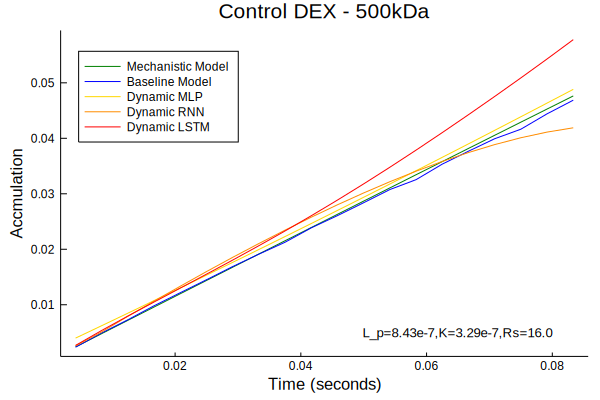

In [19]:
#Plot 4 - control DEX - 500kDa
Flux.reset!(m_LSTM)
Flux.reset!(m_RNN)
case=4
plot(t,
    [y_oi[:,case], NN_b(s_oi[:,case]),evalprofile(s_oi[:,case],m_MLP),evalprofile(s_oi[:,case],m_RNN),evalprofile(s_oi[:,case],m_LSTM)],
    title="Control DEX - 500kDa",
    ylabel="Accmulation",
    xlabel="Time (seconds)",
    label=["Mechanistic Model" "Baseline Model" "Dynamic MLP" "Dynamic RNN" "Dynamic LSTM"],
    legend=:topleft,
    grid=:off,
    #color_palette=[:green,:blue,:gold,:darkorange,:red]
    color_palette=[:green,:darkorange,:gold,:red,:blue]
)
annotate!(.065,0.005,("L_p=$(s_oi[1,case]),K=$(s_oi[2,case]),Rs=$(s_oi[3,case])",9))
#savefig("dexc_500.png")

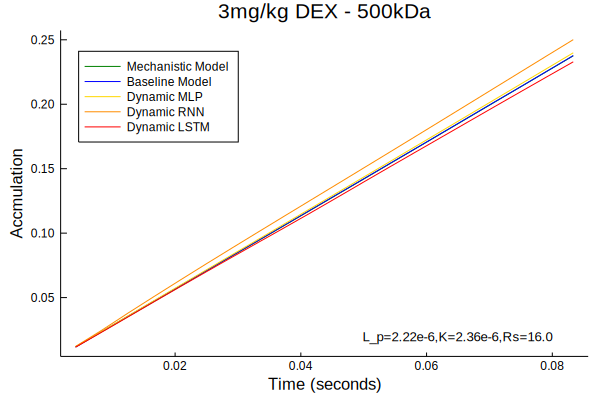

In [20]:
#Plot 5 - 3mg/kg DEX - 500kDa
Flux.reset!(m_LSTM)
Flux.reset!(m_RNN)
case=5
plot(t,
    [y_oi[:,case], NN_b(s_oi[:,case]),evalprofile(s_oi[:,case],m_MLP),evalprofile(s_oi[:,case],m_RNN),evalprofile(s_oi[:,case],m_LSTM)],
    title="3mg/kg DEX - 500kDa",
    ylabel="Accmulation",
    xlabel="Time (seconds)",
    label=["Mechanistic Model" "Baseline Model" "Dynamic MLP" "Dynamic RNN" "Dynamic LSTM"],
    legend=:topleft,
    grid=:off,
    #color_palette=[:green,:blue,:gold,:darkorange,:red]
    color_palette=[:green,:darkorange,:gold,:red,:blue]
)
annotate!(.065,0.02,("L_p=$(s_oi[1,case]),K=$(s_oi[2,case]),Rs=$(s_oi[3,case])",9))
#savefig("dex3_500.png")

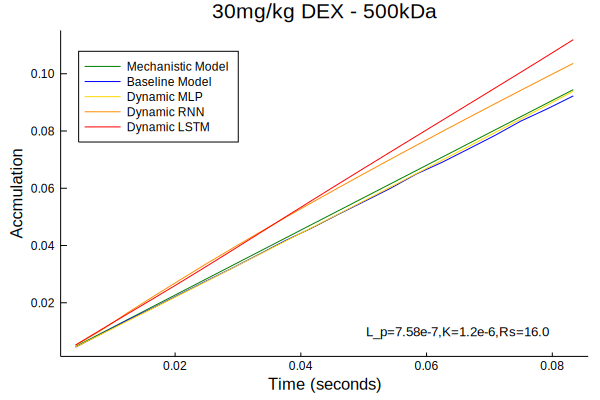

In [21]:
#Plot 6 - 30mg/kg DEX - 500kDa
Flux.reset!(m_LSTM)
Flux.reset!(m_RNN)
case=6
plot(t,
    [y_oi[:,case], NN_b(s_oi[:,case]),evalprofile(s_oi[:,case],m_MLP),evalprofile(s_oi[:,case],m_RNN),evalprofile(s_oi[:,case],m_LSTM)],
    title="30mg/kg DEX - 500kDa",
    ylabel="Accmulation",
    xlabel="Time (seconds)",
    label=["Mechanistic Model" "Baseline Model" "Dynamic MLP" "Dynamic RNN" "Dynamic LSTM"],
    legend=:topleft,
    grid=:off,
    #color_palette=[:green,:blue,:gold,:darkorange,:red]
    color_palette=[:green,:darkorange,:gold,:red,:blue]
)
annotate!(.065,0.01,("L_p=$(s_oi[1,case]),K=$(s_oi[2,case]),Rs=$(s_oi[3,case])",9))
#savefig("dex30_500.png")

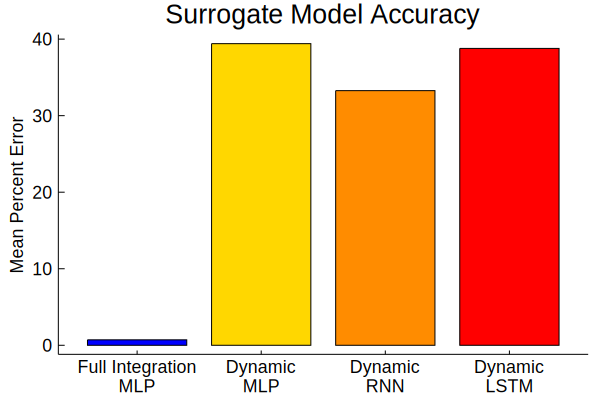

In [22]:
#Plot a bar chart of the accuracy of each model
vals = [ mean_error_func(XS,YS,m_baseline),evalmpe(S,YS,m_MLP),evalmpe(S,YS,m_RNN),evalmpe(S,YS,m_LSTM)]
cats = ["Full Integration\nMLP", "Dynamic\nMLP", "Dynamic\nRNN", "Dynamic\nLSTM"]
colorMap = Dict("Full Integration\nMLP"=>"blue","Dynamic\nMLP"=>"gold","Dynamic\nRNN"=>"darkorange","Dynamic\nLSTM"=>"red")
colours = [colorMap[i] for i in cats]
accplot=bar(cats,vals,colour=colours,grid=false,legend=false,
ylabel = "Mean Percent Error",
title = "Surrogate Model Accuracy",
guidefontsize=12,
tickfontsize=12,
titlefontsize=18
#titlefont=font(22,"Calibri")
)
#savefig(accplot,"accplot.png")